In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, BackendSampler
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import VQD, VQE, SamplingVQE, NumPyEigensolver
from qiskit_algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit_algorithms.gradients import DerivativeType, LinCombQGT, LinCombEstimatorGradient
from qiskit_algorithms.state_fidelities import BaseStateFidelity, ComputeUncompute

from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition
from qiskit_nature.second_q.hamiltonians.ising_model import IsingModel
from qiskit.quantum_info import Operator
# from qiskit.quantum_info.operators.base_operator import BaseOperator

import matplotlib.pyplot as plt

from qiskit import Aer
import numpy as np

In [2]:
simulator = Aer.get_backend('aer_simulator')
counts = []
values = []
steps = []
# aer_backend = BackendEstimator(simulator, options={"shots": 500})
# machine = 'H1-2E'
# backend_emu = QuantinuumBackend(device_name=machine)
# backend_emu.login()
# qis_backend = TketBackend(backend_emu, backend_emu.default_compilation_pass(optimisation_level=2))
# qestimator = BackendEstimator(qis_backend, options={"shots": 100})

In [3]:
class Params:
    def __init__(self, num_qubits: int, no_of_states_to_compute: int, use_quant, 
                 uniform_interaction, uniform_onsite_potential):
        self.num_qubits = num_qubits
        self.no_of_states_to_compute = no_of_states_to_compute
        self.hamiltonian_op = self.__get_hamiltonian__(uniform_interaction, uniform_onsite_potential)
        self.use_quant = use_quant
    
            
    
    def __get_hamiltonian__(self, uniform_interaction, uniform_onsite_potential):
        line_lattice = LineLattice(num_nodes=self.num_qubits, boundary_condition=BoundaryCondition.OPEN)

        ising_model = IsingModel(
            line_lattice.uniform_parameters(
                uniform_interaction,
                uniform_onsite_potential
            ),
        )
        ham = ising_model.second_q_op()
        ham_operator = Operator(ham.to_matrix())
        eivs = list(np.linalg.eigvals(ham_operator))
        eivs.sort()
        # print('numpy soln', eivs)
        return SparsePauliOp.from_operator(ham_operator)


def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

VQD res:  [-1.54893304 -0.61962731 -1.55226057 -0.82911253 -0.76500295 -0.79412003]
Sim res:  [-1.60992743 -1.55508531 -1.29612196 -1.24127984 -1.10123027 -1.04638814]


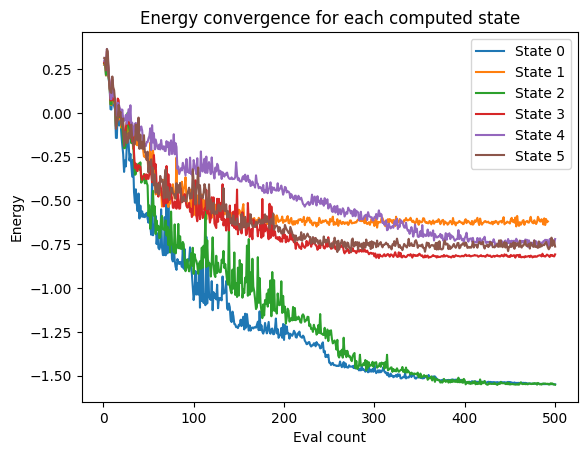

In [19]:
counts = []
values = []
steps = []

if __name__ == "__main__":
    # TODO: which on has to be less than 1?
    optimizer_cobyla = COBYLA(maxiter=500)
    params = Params(num_qubits = 6, no_of_states_to_compute = 6, use_quant = False, 
                    uniform_interaction=-1.0, uniform_onsite_potential=-0.4)
    betas = [1]*params.no_of_states_to_compute
    ansatz = EfficientSU2(params.num_qubits, entanglement="linear")

    
    estimator = Estimator()
    
    sampler = BackendSampler(simulator)
    fidelity = ComputeUncompute(sampler)

    vqd = VQD(estimator, fidelity, ansatz, optimizer_cobyla, k=params.no_of_states_to_compute, betas=betas, callback=callback)
    result = vqd.compute_eigenvalues(params.hamiltonian_op)
    print('VQD res: ', result.eigenvalues.real)

    exact_solver = NumPyEigensolver(k=params.no_of_states_to_compute)
    exact_result = exact_solver.compute_eigenvalues(params.hamiltonian_op)
    ref_values = exact_result.eigenvalues
    print('Sim res: ', ref_values)

    steps = np.asarray(steps)
    counts = np.asarray(counts)
    values = np.asarray(values)

    for i in range(1, params.no_of_states_to_compute+1):
        _counts = counts[np.where(steps == i)]
        _values = values[np.where(steps == i)]
        plt.plot(_counts, _values, label=f"State {i-1}")

    plt.xlabel("Eval count")
    plt.ylabel("Energy")
    plt.title("Energy convergence for each computed state")
    plt.legend(loc="upper right")
    plt.show()


# Transition Prob.

In [ ]:
# from_state = 0
# to_state = 1
# qc = QuantumCircuit(2*params.num_qubits + 1, 1)
# qc.initialize(Ceigenstate[from_state], range(1,n+1))
# qc.initialize(Ceigenstate[to_state], range(n+1, (2 * n)+1))

# qc.h(0)
# for i in range(n):
#     qc.cswap(0, i+1, i+1 + n)
# qc.h(0)
# qc.measure(0, 0)
# simulator = Aer.get_backend('qasm_simulator')
# compiled_circuit = transpile(qc, simulator)
# job = execute(compiled_circuit, simulator, shots=1024)
# result = job.result()
# counts = result.get_counts()
# # Calculate the probability of measuring |0> on the ancilla qubit
# p_zero = counts.get('0', 0) / 1024
# print("Probability of 0 ",from_state," to ",to_state," is ", p_zero)
# print(np.sqrt(np.real(2 * p_zero - 1)))